# Chromosome Painting

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
using DataFrames
using Plots
# using ProfileView

BLAS.set_num_threads(1)

# Download population data

Download [population code](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/) for each 1000 genomes sample. Different population code is explained [here](https://www.internationalgenome.org/category/population/). 

In [2]:
# run this code in terminal
# wget -r -l3 -N --no-parent ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/

In [3]:
# map population to super-population
pop_to_superpop = Dict{String, String}()

# 5 east asian
pop_to_superpop["CHB"] = "EAS"; pop_to_superpop["JPT"] = "EAS"; pop_to_superpop["CHS"] = "EAS"; 
pop_to_superpop["CDX"] = "EAS"; pop_to_superpop["KHV"] = "EAS"; 

# 5 european
pop_to_superpop["CEU"] = "EUR"; pop_to_superpop["TSI"] = "EUR"; pop_to_superpop["FIN"] = "EUR";
pop_to_superpop["GBR"] = "EUR"; pop_to_superpop["IBS"] = "EUR";

# 7 african
pop_to_superpop["YRI"] = "AFR"; pop_to_superpop["LWK"] = "AFR"; pop_to_superpop["GWD"] = "AFR"; 
pop_to_superpop["MSL"] = "AFR"; pop_to_superpop["ESN"] = "AFR"; pop_to_superpop["ASW"] = "AFR"; 
pop_to_superpop["ACB"] = "AFR"; 

# 4 ad mixed americans
pop_to_superpop["MXL"] = "AMR"; pop_to_superpop["PUR"] = "AMR"; pop_to_superpop["CLM"] = "AMR"; 
pop_to_superpop["PEL"] = "AMR";

# 5 south asian
pop_to_superpop["GIH"] = "SAS"; pop_to_superpop["PJL"] = "SAS"; pop_to_superpop["BEB"] = "SAS"; 
pop_to_superpop["STU"] = "SAS"; pop_to_superpop["ITU"] = "SAS";

# Get each sample's population and super-population origin

In [4]:
cd("/Users/biona001/.julia/dev/MendelImpute/manuscript/sec4.2")
refID_to_population = Dict{String, String}()
refID_to_superpopulation = Dict{String, String}()
for population in readdir("data/")
    for sample in readdir("data/" * population)
        sample == ".DS_Store" && continue
        refID_to_population[sample] = population
        refID_to_superpopulation[sample] = pop_to_superpop[population]
    end
end
refID_to_superpopulation

Dict{String,String} with 2709 entries:
  "HG01791" => "EUR"
  "HG02736" => "SAS"
  "HG00182" => "EUR"
  "HG03914" => "SAS"
  "HG00149" => "EUR"
  "NA12156" => "EUR"
  "HG02642" => "AFR"
  "HG02851" => "AFR"
  "NA19835" => "AFR"
  "NA19019" => "AFR"
  "HG01131" => "AMR"
  "HG03725" => "SAS"
  "HG03578" => "AFR"
  "NA18550" => "EAS"
  "HG02401" => "EAS"
  "HG01350" => "AMR"
  "HG03973" => "SAS"
  "NA07000" => "EUR"
  "HG01709" => "EUR"
  "HG01395" => "AMR"
  "HG02388" => "EAS"
  "HG01980" => "AMR"
  "HG01979" => "AMR"
  "HG01122" => "AMR"
  "HG03869" => "SAS"
  ⋮         => ⋮

# Compute phase information

Here the target and reference files are generated with the `aim_select.ipynb` notebook under `aim_markers`. 

In [5]:
# compute each person's phase information
Random.seed!(2020)
tgtfile = "target.chr18.typedOnly.aim.masked.vcf.gz"
reffile = "ref.chr18.jlso"
outfile = "mendel.imputed.jlso"
@time ph = phase(tgtfile, reffile, outfile);

Number of threads = 1
Importing reference haplotype data...


Importing genotype file...100%|█████████████████████████| Time: 0:00:06
Computing optimal haplotypes...100%|████████████████████| Time: 0:01:02
Phasing...100%|█████████████████████████████████████████| Time: 0:00:36


Total windows = 748, averaging ~ 507 unique haplotypes per window.

Timings: 
    Data import                     = 18.2035 seconds
        import target data             = 7.60776 seconds
        import compressed haplotypes   = 10.5957 seconds
    Computing haplotype pair        = 62.7517 seconds
        BLAS3 mul! to get M and N      = 1.14874 seconds per thread
        haplopair search               = 56.6546 seconds per thread
        initializing missing           = 1.04499 seconds per thread
        allocating and viewing         = 0.133745 seconds per thread
        index conversion               = 0.0645646 seconds per thread
    Phasing by win-win intersection = 36.5779 seconds
        Window-by-window intersection  = 1.53365 seconds per thread
        Breakpoint search              = 33.5464 seconds per thread
        Recording result               = 0.586622 seconds per thread
    Imputation                     = 4.38035 seconds
        Imputing missing               = 0.02

In [6]:
length(ph) # number of imputed samples

811

# Sample composition

In [7]:
# need compressed reference panel
reffile = "ref.chr18.jlso"
compressed_Hunique = JLSO.load(reffile)[:compressed_Hunique]
panelID = compressed_Hunique.sampleID

# get sample's ancestry
tgtfile = "target.chr18.typedOnly.aim.masked.vcf.gz"
reader = VCF.Reader(openvcf(tgtfile, "r"))
tgtID  = VCF.header(reader).sampleID
sample_population = [refID_to_population[id] for id in tgtID];
sample_superpopulation = [refID_to_superpopulation[id] for id in tgtID];

# Percentage plots for sample composition

In [8]:
# generated here: https://mdigi.tools/color-shades/#008000
# Red ≈ Asian, Blue ≈ European, Green ≈ Africa

goodcolors = [colorant"#ff9595", colorant"#ff6a6a", colorant"#ff4040", colorant"#ff1515", 
    colorant"#ea0000", colorant"#bf0000", colorant"#950000", colorant"#a4a4ff", 
    colorant"#8080ff", colorant"#5b5bff", colorant"#3737ff", colorant"#0000b3", 
    colorant"#b3ffb3", colorant"#80ff80", colorant"#1aff1a", colorant"#00e600", 
    colorant"#008000"]

In [9]:
# super population colors generated here: https://sashamaps.net/docs/resources/20-colors/
# Blue ≈ European, Red = south Asian, Green = African, maroon=east asian
continent = ["SAS", "EAS", "EUR", "AFR"]
continent_colors = [colorant"#e6194B", colorant"#800000", colorant"#4363d8", colorant"#bfef45"]

In [10]:
findall(x -> x == "PUR", sample_population)

104-element Array{Int64,1}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 127
 155
 156
 157
 158
 159
 160
 161
 162
 163
 164
 165

  0.000130 seconds (5 allocations: 560 bytes)
  0.000147 seconds (5 allocations: 560 bytes)
  0.000246 seconds (5 allocations: 560 bytes)


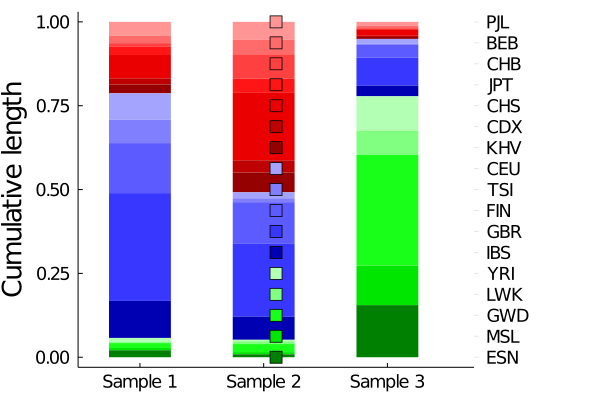

GKS: Viewport is not within the NDC unit square in routine SET_VIEWPORT


In [13]:
populations = ["PJL", "BEB",            # 2 south asian
    "CHB", "JPT", "CHS", "CDX", "KHV",  # 5 east asian
    "CEU", "TSI", "FIN", "GBR", "IBS",  # 5 european
    "YRI", "LWK", "GWD", "MSL", "ESN"]  # 5 african

# PUR, PEL, ASW
sample1 = 2
sample2 = 339
sample3 = 704

@time sample1_comp = composition(ph[sample1], panelID, refID_to_population, populations=populations)
@time sample2_comp = composition(ph[sample2], panelID, refID_to_population, populations=populations)
@time sample3_comp = composition(ph[sample3], panelID, refID_to_population, populations=populations)

#
# create plots
#
using StatsPlots, FixedPointNumbers
npopulations = length(populations)

mydata = zeros(3, npopulations)
copyto!(@view(mydata[1, :]), sample1_comp)
copyto!(@view(mydata[2, :]), sample2_comp)
copyto!(@view(mydata[3, :]), sample3_comp)

pop_colors = Matrix{RGB{Normed{UInt8,8}}}(undef, 3, npopulations)
copyto!(@view(pop_colors[1, :]), goodcolors)
copyto!(@view(pop_colors[2, :]), goodcolors)
copyto!(@view(pop_colors[3, :]), goodcolors)

xnames = ["Sample 1", "Sample 2", "Sample 3"]

# create percentage plot
percent_plt = groupedbar(mydata, bar_position = :stack, bar_width=0.5, label=:none, 
    lw = 0, color=pop_colors, xticks=(1:1:3, xnames), yticks=(0:0.25:1), 
    ylabel="Cumulative length", yguidefontsize=18,
    ytickfont=font(12), xtickfont=font(12), grid=false, xlim=(0.5, 3.7),
    right_margin = 30Plots.mm)

# create a plot for legend
color_x = ones(17)
color_y = collect(1:17)
scatter!(color_x, color_y, color=reverse(goodcolors), ytick=(1:1:17, reverse(populations)), 
    xrange=(0.9, 1.1), xtick=false, label=:none, markersize=6, ytickfont=font(12),
    grid=false, framestyle=:grid, mirror=true, tick_direction=:out, markershape=:rect,
    inset = (1, bbox(-0.05, -0.1, 0.05, 1.1, :bottom, :right)), subplot = 2)

# add annotations
# plot!(legend_plt, [4.3, 4.3], [0.81, 0.03], linewidth=3.0, color=:black, label=false, arrow=true)
# plot!(percent_plt, [1.3, 1.3], [0.03, 0.81], linewidth=3.0, color=:black, label=false, arrow=true)
# annotate!(percent_plt, 1.4, 0.72 , text("Europrean/Admixed-Americans", :left, rotation = 270))
# plot!(percent_plt, [2.3, 2.3], [0.99, 0.26], linewidth=3.0, color=:black, label=false, arrow=true)
# plot!(percent_plt, [2.3, 2.3], [0.26, 0.99], linewidth=3.0, color=:black, label=false, arrow=true)
# annotate!(percent_plt, 2.4, 0.77 , text("S/E Asians", :left, rotation = 270))
# plot!(percent_plt, [3.3, 3.3], [0.77, 0.01], linewidth=3.0, color=:black, label=false, arrow=true)
# plot!(percent_plt, [3.3, 3.3], [0.01, 0.77], linewidth=3.0, color=:black, label=false, arrow=true)
# annotate!(percent_plt, 3.4, 0.47 , text("Africans", :left, rotation = 270))


  0.000113 seconds (5 allocations: 336 bytes)
  0.000125 seconds (5 allocations: 336 bytes)
  0.000150 seconds (5 allocations: 336 bytes)
sample 1 = 0.063 S. asian
sample 1 = 0.15 E. asian
sample 1 = 0.729 European
sample 1 = 0.058 Africans

sample 2 = 0.097 S. asian
sample 2 = 0.412 E. asian
sample 2 = 0.44 European
sample 2 = 0.052 Africans

sample 3 = 0.018 S. asian
sample 3 = 0.033 E. asian
sample 3 = 0.171 European
sample 3 = 0.778 Africans



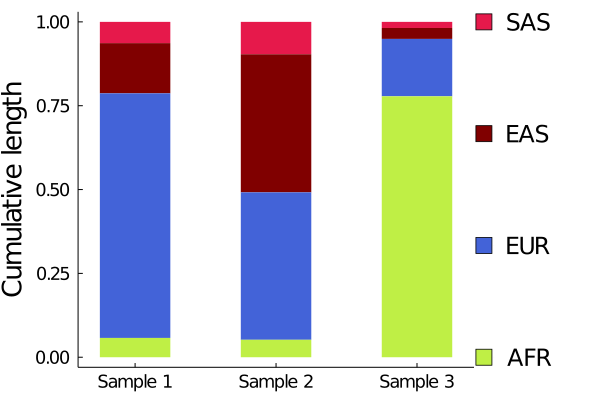

In [14]:
continent = ["SAS", "EAS", "EUR", "AFR"]
@time sample1_comp = composition(ph[sample1], panelID, refID_to_superpopulation, populations=continent)
@time sample2_comp = composition(ph[sample2], panelID, refID_to_superpopulation, populations=continent)
@time sample3_comp = composition(ph[sample3], panelID, refID_to_superpopulation, populations=continent)

println("sample 1 = ", round(sample1_comp[1], digits=3), " S. asian")
println("sample 1 = ", round(sample1_comp[2], digits=3), " E. asian")
println("sample 1 = ", round(sample1_comp[3], digits=3), " European")
println("sample 1 = ", round(sample1_comp[4], digits=3), " Africans\n")

println("sample 2 = ", round(sample2_comp[1], digits=3), " S. asian")
println("sample 2 = ", round(sample2_comp[2], digits=3), " E. asian")
println("sample 2 = ", round(sample2_comp[3], digits=3), " European")
println("sample 2 = ", round(sample2_comp[4], digits=3), " Africans\n")
    
println("sample 3 = ", round(sample3_comp[1], digits=3), " S. asian")
println("sample 3 = ", round(sample3_comp[2], digits=3), " E. asian")
println("sample 3 = ", round(sample3_comp[3], digits=3), " European")
println("sample 3 = ", round(sample3_comp[4], digits=3), " Africans\n")

#
# create plots
#
using StatsPlots, FixedPointNumbers
ncontinent = length(continent)

mydata = zeros(3, ncontinent)
copyto!(@view(mydata[1, :]), sample1_comp)
copyto!(@view(mydata[2, :]), sample2_comp)
copyto!(@view(mydata[3, :]), sample3_comp)

pop_colors = Matrix{RGB{Normed{UInt8,8}}}(undef, 3, ncontinent)
copyto!(@view(pop_colors[1, :]), continent_colors)
copyto!(@view(pop_colors[2, :]), continent_colors)
copyto!(@view(pop_colors[3, :]), continent_colors)

xnames = ["Sample 1", "Sample 2", "Sample 3"]

# create percentage plot
percent_plt2 = groupedbar(mydata, bar_position = :stack, bar_width=0.5, label=:none, 
    lw = 0, color=pop_colors, xticks=(1:1:3, xnames), yticks=(0:0.25:1), 
    ylabel="Cumulative length", yguidefontsize=18,
    ytickfont=font(12), xtickfont=font(12), grid=false,
    right_margin = 30Plots.mm)

# create a plot for legend
color_x = ones(4)
color_y = collect(1:1:4)
admixture_continent = scatter!(color_x, color_y, color=reverse(continent_colors), ytick=(1:1:4, reverse(continent)), 
    xrange=(0.9, 1.1), xtick=false, label=:none, markersize=8, ytickfont=font(16),
    grid=false, framestyle=:grid, mirror=true, tick_direction=:out, markershape=:rect,
    inset = (1, bbox(-0.05, 0.0, 0.05, 1.0, :bottom, :right)), subplot = 2)

In [23]:
cd("/Users/biona001/.julia/dev/MendelImpute/manuscript/sec4.2")
savefig(admixture_continent, "admixture_superpopulation.png") # remember to set dpi=300

# Try painting an actual chromosome

Generated colors here: https://mdigi.tools/color-shades/#008000 and https://sashamaps.net/docs/resources/20-colors/.

Colors are arranged such that:
+ Blue ≈ European/American
+ Red ≈ Asian
+ Green ≈ African

In [15]:
@time sample1_s1_pop, sample1_s2_pop = paint(ph[sample1], panelID, refID_to_population, populations=populations)
@time sample2_s1_pop, sample2_s2_pop = paint(ph[sample2], panelID, refID_to_population, populations=populations)
@time sample3_s1_pop, sample3_s2_pop = paint(ph[sample3], panelID, refID_to_population, populations=populations);

@time sample1_s1_cont, sample1_s2_cont = paint(ph[sample1], panelID, refID_to_superpopulation, populations=continent)
@time sample2_s1_cont, sample2_s2_cont = paint(ph[sample2], panelID, refID_to_superpopulation, populations=continent)
@time sample3_s1_cont, sample3_s2_cont = paint(ph[sample3], panelID, refID_to_superpopulation, populations=continent);

  0.089148 seconds (117.69 k allocations: 5.943 MiB)
  0.000090 seconds (12 allocations: 12.781 KiB)
  0.000111 seconds (12 allocations: 14.906 KiB)
  0.000087 seconds (12 allocations: 11.406 KiB)
  0.000074 seconds (12 allocations: 12.781 KiB)
  0.000092 seconds (12 allocations: 14.906 KiB)


In [16]:
# population colors
sample1_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample1_s1_pop[2]]
sample1_s1_colors = reshape(sample1_s1_colors, 1, length(sample1_s1_colors))

sample1_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample1_s2_pop[2]]
sample1_s2_colors = reshape(sample1_s2_colors, 1, length(sample1_s2_colors))

sample2_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample2_s1_pop[2]]
sample2_s1_colors = reshape(sample2_s1_colors, 1, length(sample2_s1_colors))

sample2_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample2_s2_pop[2]]
sample2_s2_colors = reshape(sample2_s2_colors, 1, length(sample2_s2_colors))

sample3_s1_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample3_s1_pop[2]]
sample3_s1_colors = reshape(sample3_s1_colors, 1, length(sample3_s1_colors))

sample3_s2_colors = [goodcolors[findfirst(x -> x == pop, populations)] for pop in sample3_s2_pop[2]]
sample3_s2_colors = reshape(sample3_s2_colors, 1, length(sample3_s2_colors));

# super-population colors
sample1_s1_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample1_s1_cont[2]]
sample1_s1_cont_colors = reshape(sample1_s1_cont_colors, 1, length(sample1_s1_cont_colors))

sample1_s2_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample1_s2_cont[2]]
sample1_s2_cont_colors = reshape(sample1_s2_cont_colors, 1, length(sample1_s2_cont_colors))

sample2_s1_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample2_s1_cont[2]]
sample2_s1_cont_colors = reshape(sample2_s1_cont_colors, 1, length(sample2_s1_cont_colors))

sample2_s2_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample2_s2_cont[2]]
sample2_s2_cont_colors = reshape(sample2_s2_cont_colors, 1, length(sample2_s2_cont_colors))

sample3_s1_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample3_s1_cont[2]]
sample3_s1_cont_colors = reshape(sample3_s1_cont_colors, 1, length(sample3_s1_cont_colors))

sample3_s2_cont_colors = [continent_colors[findfirst(x -> x == pop, continent)] for pop in sample3_s2_cont[2]]
sample3_s2_cont_colors = reshape(sample3_s2_cont_colors, 1, length(sample3_s2_cont_colors));

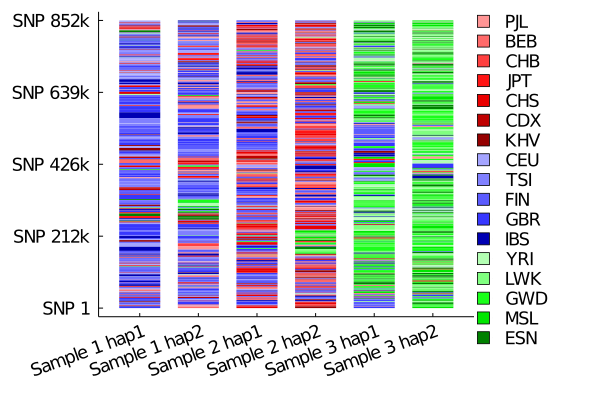

In [32]:
using StatsPlots, FixedPointNumbers

sample1_s1l = length(sample1_s1_pop[1])
sample1_s2l = length(sample1_s2_pop[1])
sample2_s1l = length(sample2_s1_pop[1])
sample2_s2l = length(sample2_s2_pop[1])
sample3_s1l = length(sample3_s1_pop[1])
sample3_s2l = length(sample3_s2_pop[1])
maxlen = max(sample1_s1l, sample1_s2l, sample2_s1l, sample2_s2l, sample3_s1l, sample3_s2l)

mydata = zeros(6, maxlen)
copyto!(@view(mydata[1, 1:sample1_s1l]), sample1_s1_pop[1])
copyto!(@view(mydata[2, 1:sample1_s2l]), sample1_s2_pop[1])
copyto!(@view(mydata[3, 1:sample2_s1l]), sample2_s1_pop[1])
copyto!(@view(mydata[4, 1:sample2_s2l]), sample2_s2_pop[1])
copyto!(@view(mydata[5, 1:sample3_s1l]), sample3_s1_pop[1])
copyto!(@view(mydata[6, 1:sample3_s2l]), sample3_s2_pop[1])

pop_colors = Matrix{RGB{Normed{UInt8,8}}}(undef, 6, maxlen)
copyto!(@view(pop_colors[1, 1:sample1_s1l]), sample1_s1_colors)
copyto!(@view(pop_colors[2, 1:sample1_s2l]), sample1_s2_colors)
copyto!(@view(pop_colors[3, 1:sample2_s1l]), sample2_s1_colors)
copyto!(@view(pop_colors[4, 1:sample2_s2l]), sample2_s2_colors)
copyto!(@view(pop_colors[5, 1:sample3_s1l]), sample3_s1_colors)
copyto!(@view(pop_colors[6, 1:sample3_s2l]), sample3_s2_colors)

xnames = ["Sample 1 hap1", "Sample 1 hap2", "Sample 2 hap1", "Sample 2 hap2", 
        "Sample 3 hap1", "Sample 3 hap2"]
ynames = ["SNP 1", "SNP 212k", "SNP 426k", "SNP 639k", "SNP 852k"]

# color haplotypes
chrom_plt = groupedbar(mydata, bar_position = :stack, bar_width=0.7, label=:none, 
    lw = 0, color=pop_colors, xticks=(1:1:6, xnames), yticks=(0:0.25:1, ynames),
    ytickfont=font(12), xtickfont=font(12), xrotation=20, grid=false,
    right_margin = 30Plots.mm)

# create a plot for legend
color_x = ones(17)
color_y = collect(1:1:17)
scatter!(color_x, color_y, color=reverse(goodcolors), ytick=(1:1:17, reverse(populations)), 
    xrange=(0.9, 1.1), xtick=false, label=:none, markersize=6, ytickfont=font(12),
    grid=false, framestyle=:grid, mirror=true, tick_direction=:out, markershape=:rect,
    inset = (1, bbox(-0.05, -0.1, 0.05, 1.1, :bottom, :right)), subplot = 2)

### By continent

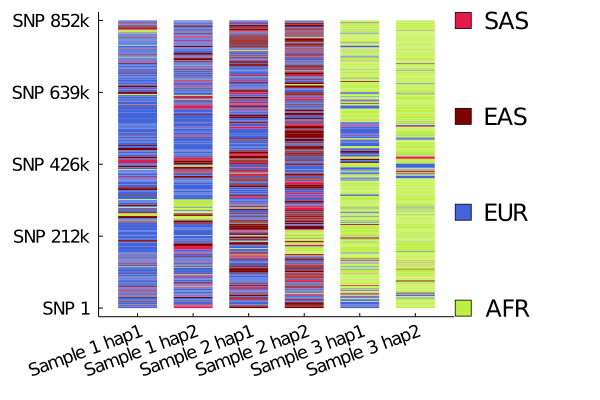

In [29]:
using StatsPlots, FixedPointNumbers

sample1_s1l = length(sample1_s1_cont[1])
sample1_s2l = length(sample1_s2_cont[1])
sample2_s1l = length(sample2_s1_cont[1])
sample2_s2l = length(sample2_s2_cont[1])
sample3_s1l = length(sample3_s1_cont[1])
sample3_s2l = length(sample3_s2_cont[1])
maxlen = max(sample1_s1l, sample1_s2l, sample2_s1l, sample2_s2l, sample3_s1l, sample3_s2l)

# mylabels = reshape(populations, 1, 26)
mydata = zeros(6, maxlen)
copyto!(@view(mydata[1, 1:sample1_s1l]), sample1_s1_cont[1])
copyto!(@view(mydata[2, 1:sample1_s2l]), sample1_s2_cont[1])
copyto!(@view(mydata[3, 1:sample2_s1l]), sample2_s1_cont[1])
copyto!(@view(mydata[4, 1:sample2_s2l]), sample2_s2_cont[1])
copyto!(@view(mydata[5, 1:sample3_s1l]), sample3_s1_cont[1])
copyto!(@view(mydata[6, 1:sample3_s2l]), sample3_s2_cont[1])

cont_colors = Matrix{RGB{Normed{UInt8,8}}}(undef, 6, maxlen)
copyto!(@view(cont_colors[1, 1:sample1_s1l]), sample1_s1_cont_colors)
copyto!(@view(cont_colors[2, 1:sample1_s2l]), sample1_s2_cont_colors)
copyto!(@view(cont_colors[3, 1:sample2_s1l]), sample2_s1_cont_colors)
copyto!(@view(cont_colors[4, 1:sample2_s2l]), sample2_s2_cont_colors)
copyto!(@view(cont_colors[5, 1:sample3_s1l]), sample3_s1_cont_colors)
copyto!(@view(cont_colors[6, 1:sample3_s2l]), sample3_s2_cont_colors)

xnames = ["Sample 1 hap1", "Sample 1 hap2", "Sample 2 hap1", "Sample 2 hap2", 
        "Sample 3 hap1", "Sample 3 hap2"]
ynames = ["SNP 1", "SNP 212k", "SNP 426k", "SNP 639k", "SNP 852k"]

# color haplotypes
chrom_plt2 = groupedbar(mydata, bar_position = :stack, bar_width=0.7, label=:none, 
    lw = 0, color=cont_colors, xticks=(1:1:6, xnames), yticks=(0:0.25:1, ynames),
    ytickfont=font(12), xtickfont=font(12), xrotation=20, right_margin = 35Plots.mm,
    grid=false)

# create a plot for legend
color_x = ones(4)
color_y = collect(1:1:4)
admixture_chrom_plt = scatter!(color_x, color_y, color=reverse(continent_colors), ytick=(1:1:4, reverse(continent)), 
    xrange=(0.9, 1.1), xtick=false, label=:none, markersize=8, ytickfont=font(16),
    grid=false, framestyle=:grid, mirror=true, tick_direction=:out, markershape=:rect,
    inset = (1, bbox(-0.05, 0.0, 0.05, 1.0, :bottom, :right)), subplot = 2)

In [28]:
cd("/Users/biona001/.julia/dev/MendelImpute/manuscript/sec4.2")
savefig(admixture_chrom_plt, "admixture_chromosome.png") # remember to set dpi=300